# Predicting daily sales of each country using auto arima

In [3]:
pip install blosc2~=2.0.0

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.9 MB 2.3 MB/s eta 0:00:01
   ------- -------------------------------- 0.4/1.9 MB 4.6 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.9 MB 6.6 MB/s eta 0:00:01
   -------------------- ------------------- 1.0/1.9 MB 5.7 MB/s eta 0:00:01
   ------------------------ --------------- 1.2/1.9 MB 5.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.3/1.9 MB 5.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.4/1.9 MB 4.4 MB/s eta 0:00:01
   ------------------------------- -------- 1.5/1.9 MB 4.5 MB/s eta 0:00:01
   -------------------------------------- - 1.9/1.9 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: blosc2
    Found existing installation: blosc2 2.6.2
    Uninstalling blosc2-2.6.2:
      Successfully uninstalled blosc2-2.6.2
Note: you may need 

In [4]:
!pip install pmdarima

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('Sales.csv')
data.head()

,Date,Article_ID,Country_Code,Sold_Units
0,20170817,1132,AT,1
1,20170818,1132,AT,1
2,20170821,1132,AT,1
3,20170822,1132,AT,1
4,20170906,1132,AT,1


## Date Preprocessing

In [7]:
data.Country_Code.unique()

array(['AT', 'FI', 'FR', 'SE'], dtype=object)

In [8]:
data['Date'] = pd.to_datetime(data.Date.astype('str'), errors='raise')
data['Month'] = data['Date'].dt.month_name()
data['Year'] = data['Date'].dt.year

data['Country_Code'] = data.Country_Code.astype('category')

In [9]:
print(data.head())

        Date  Article_ID Country_Code  Sold_Units      Month  Year
0 2017-08-17        1132           AT           1     August  2017
1 2017-08-18        1132           AT           1     August  2017
2 2017-08-21        1132           AT           1     August  2017
3 2017-08-22        1132           AT           1     August  2017
4 2017-09-06        1132           AT           1  September  2017


In [10]:
grouped_df = data.groupby(['Date'], as_index=False)['Sold_Units'].sum()
print(grouped_df.head(5), end='\n\n')
print('Number of days which sold more than 3 units:', grouped_df.loc[grouped_df.Sold_Units >3, :].shape[0])

        Date  Sold_Units
0 2017-01-01           1
1 2017-01-02           3
2 2017-01-03           4
3 2017-01-04           9
4 2017-01-05           5

Number of days which sold more than 3 units: 725


## sales of the country

In [11]:
df_FR_Aug = data.loc[((data.Country_Code == 'FR') & (data.Month=='August')), :]
df_AT = data.loc[data.Country_Code == 'AT', :]
print('Total units sold in the country(AT):', np.sum(df_AT.Sold_Units))
print('Sales of the country(FR) in the month of August:', np.sum(df_FR_Aug.Sold_Units))

Total units sold in the country(AT): 1330
Sales of the country(FR) in the month of August: 121


In [12]:
def preprocess(country):        
    #set observed = True because Country_Code is category column
    df = data.groupby(['Country_Code', 'Date'], as_index=False, observed=True)['Sold_Units'].sum()        
    df_country = df.loc[df.Country_Code==country, :].set_index(['Date', 'Country_Code']).unstack(fill_value=0).asfreq('D', fill_value=0).stack().sort_index(level=1).reset_index()
    df_country_sorted = df_country.sort_values(['Date'], ascending=True)
    return (country, df_country_sorted)

#preprocess data for each country
country_dfs = {}
for country in data.Country_Code.unique():
    country, df = preprocess(country)
    country_dfs[country] = df

## non-selling days for the country('AT')

Number of non-selling days for the country('AT'): 237


<Axes: xlabel='Date', ylabel='Sold_Units'>

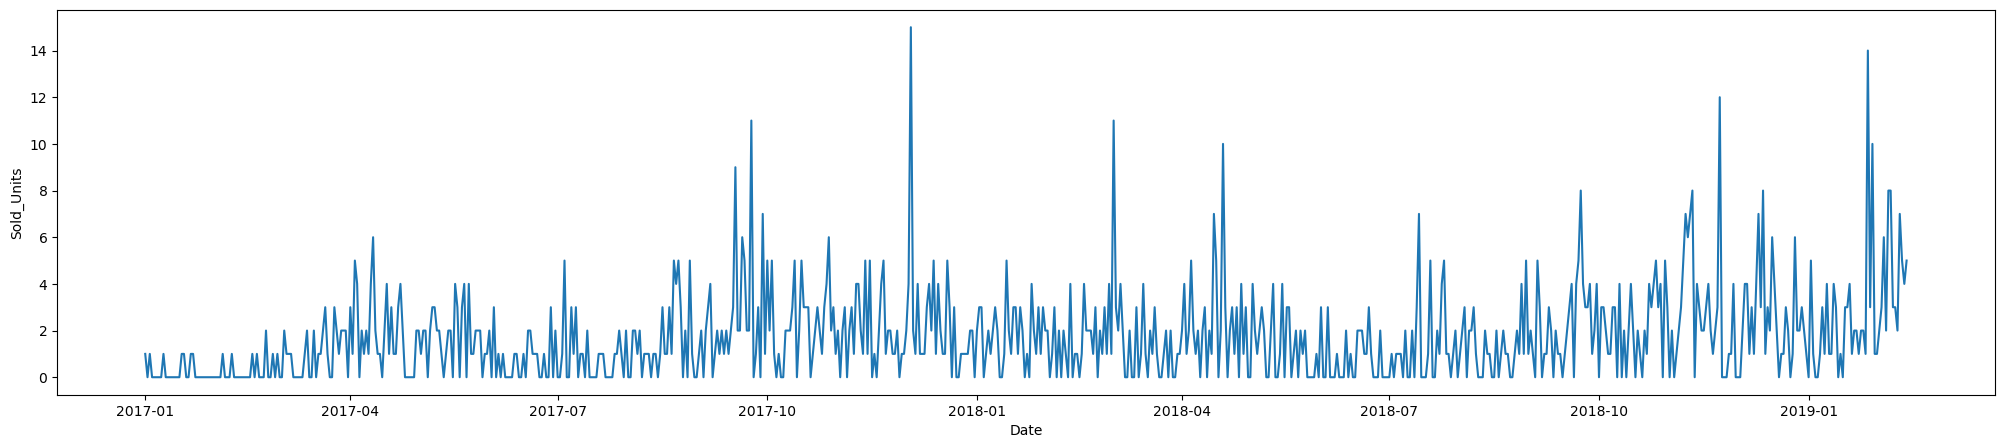

In [13]:
df_AT = country_dfs['AT']
df_AT_non_selling = df_AT.loc[df_AT['Sold_Units'] == 0, :]
print("Number of non-selling days for the country('AT'):", df_AT_non_selling.shape[0])

fig, ax = plt.subplots(figsize=(25, 5))
sns.lineplot(x='Date', y='Sold_Units', data=df_AT, ax=ax)

## Model selection and building the model

In [29]:
def fit_predict_auto_arima(train, test):
    # fit the model using training data
    model = auto_arima(train['Sold_Units'], 
                       seasonal=False, 
                       stationary=False, 
                       trace=False, 
                       error_action='ignore', 
                       suppress_warnings=True,
                       random_state=1)
    model.fit(train['Sold_Units'])

    # predict using test data
    forecast = model.predict(n_periods=len(test))
    forecast = pd.DataFrame({'Date': test.Date, 'Prediction': forecast}, index=test.index)

    # Replace NaN values in forecast with a default value (e.g., 0)
    forecast['Prediction'].fillna(0, inplace=True)

    # calculate rmse
    rmse = np.round(np.sqrt(mean_squared_error(test['Sold_Units'], forecast['Prediction'])), 3)
    
    # calculate mean absolute error
    mae = np.round(mean_absolute_error(test['Sold_Units'], forecast['Prediction']), 3)

    # plot the predictions for test set       
    fig, ax = plt.subplots(figsize=(25, 5))
    ax.plot('Date', 'Sold_Units', data=train, label='Train')
    ax.plot('Date', 'Sold_Units', data=test, label='Valid')
    ax.plot('Date', 'Prediction', data=forecast, label='Prediction')
    ax.legend()
    ax.set_title(f'Sold units for country {country} on daily basis')
    
    return model, forecast, rmse, mae


In [26]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

For country AT, RMSE=2.841, MAE=2.214
For country FI, RMSE=1.922, MAE=1.808
For country FR, RMSE=9.38, MAE=6.6
For country SE, RMSE=3.139, MAE=2.671


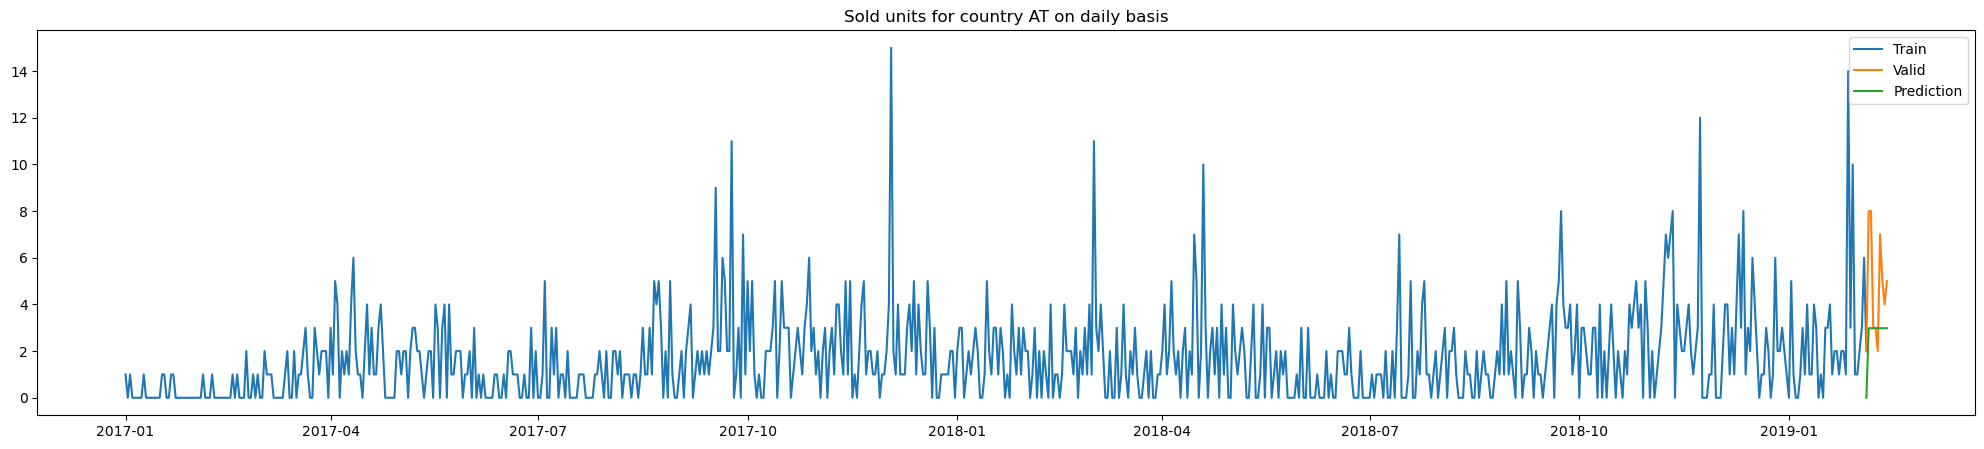

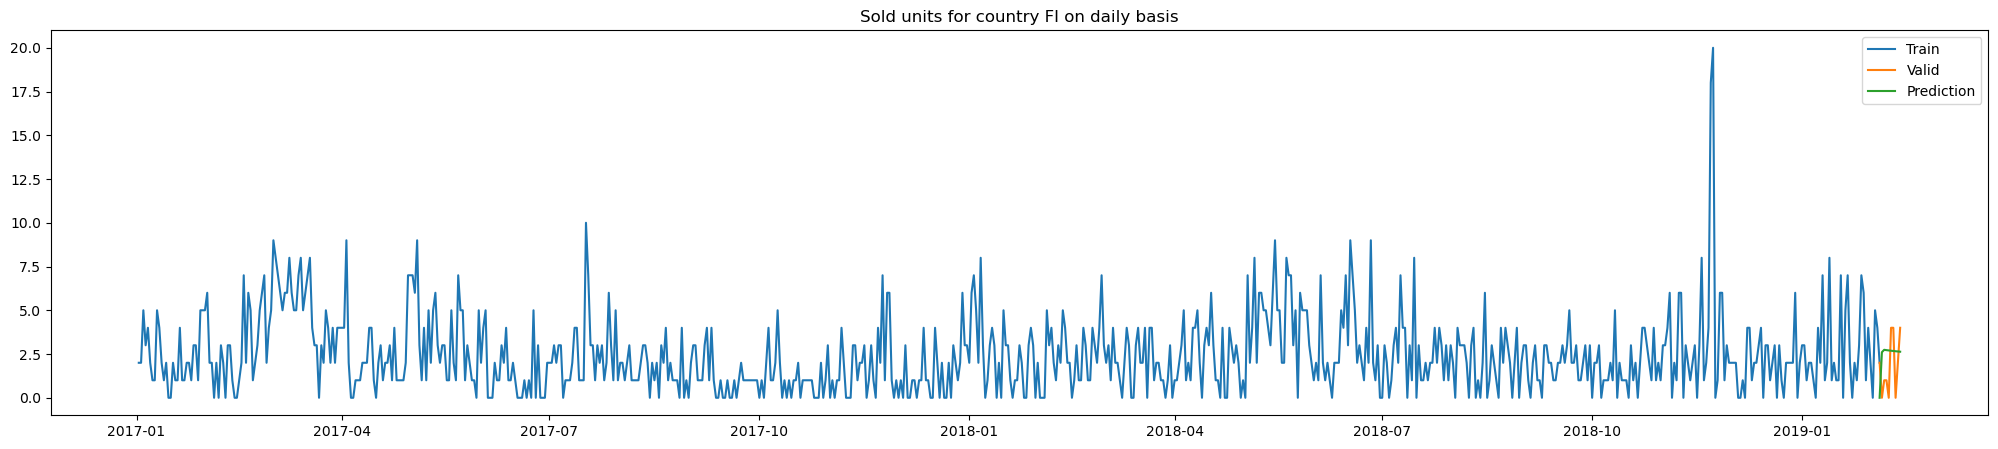

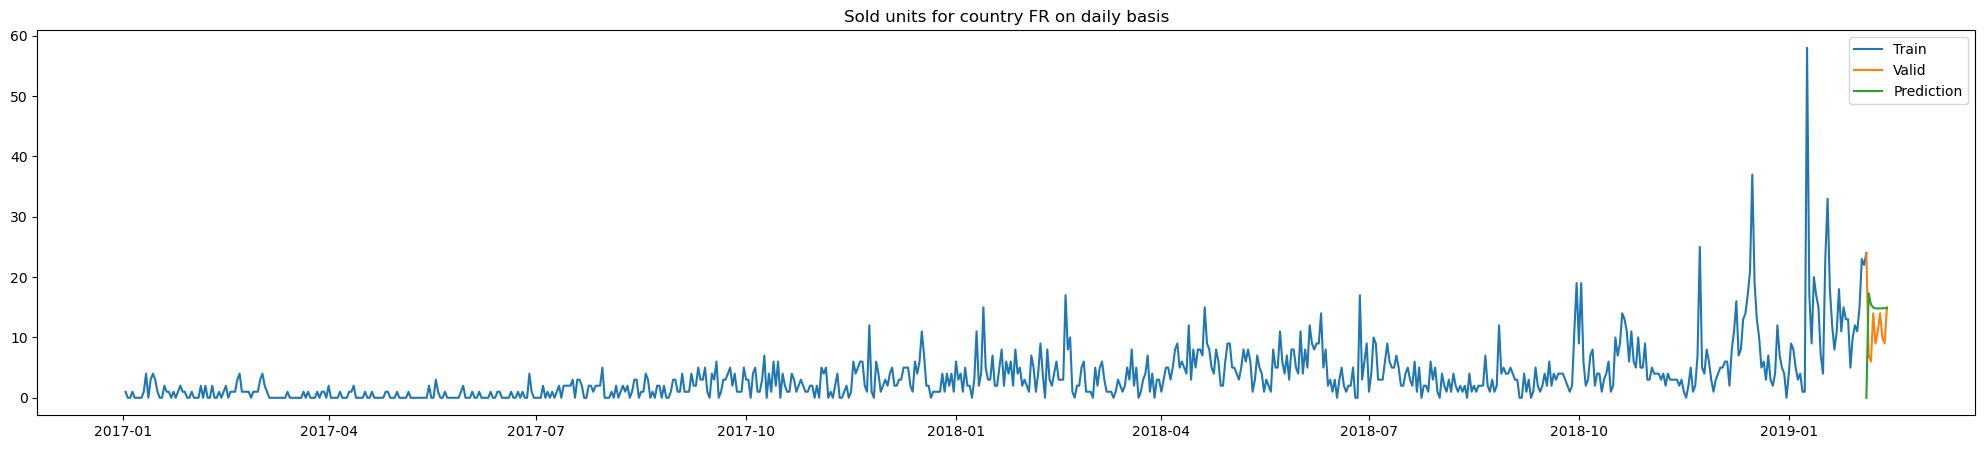

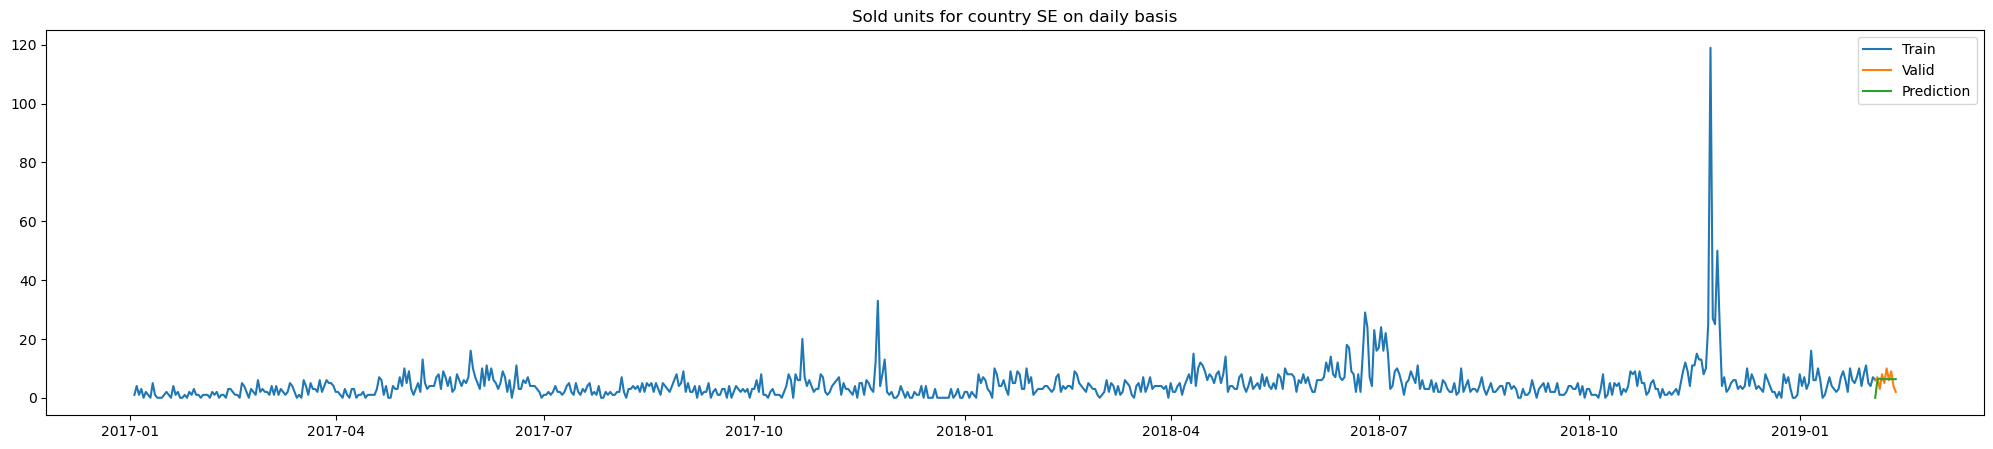

In [30]:
# for each country fit and predict    
country_error_map = {}
country_models_map = {}
for country in data.Country_Code.unique():
    df_country = country_dfs[country]
    # divide data into train and test set.
    train = df_country.loc[:len(df_country)-10, :]
    test = df_country.loc[len(df_country)-10:, :]

    # fit and predict
    model, forecast, rmse, mae = fit_predict_auto_arima(train, test)
    print(f'For country {country}, RMSE={rmse}, MAE={mae}')
    country_error_map[country] = mae
    country_models_map[country] = model


## Summary

In [31]:
country_models_map['AT'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  765
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1530.602
Date:                Sat, 25 May 2024   AIC                           3065.205
Time:                        13:40:41   BIC                           3074.482
Sample:                             0   HQIC                          3068.776
                                - 765                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9367      0.011    -81.552      0.000      -0.959      -0.914
sigma2         3.2097      0.070     45.750      0.000       3.072       3.347
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):              3003.02
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             2.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""